In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, lax, vmap, jit
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import grad
import time

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


from interpolate import interpolate_nd_jax
from smoothing import velbroad, batch_smooth_scan, fast_smooth4_variable_sigma, fast_smooth5_variable_sigma
from smoothing import fast_smooth2, fast_smooth3, fast_smooth4
import setup
import os

In [2]:
alf_home = os.environ.get('ALF_HOME')
jalf_home = os.environ.get('JALF_HOME')

burn_in_length = 500 #numpyro calls this "warmup"
samples_length = 1000

ang_per_poly_degree = 100

error_mult = 1.5
error_mult_vel = 2.5

#infiles
ssp_type = 'VCJ_v9'
chem_type='atlas'
atlas_imf='krpa'

grange=50

In [3]:
infiles = alf_home+'infiles/'
lam_ssp, ssp_value_grid, flux_ssp_grid = setup.read_ssp_models(infiles,ssp_type='VCJ_v9')
lam_chem, chem_dict, chem_names = setup.read_chem_models(infiles)

In [4]:
indata = jalf_home+'indata/'
filename = 'NGC2695_KCWI_3ring_2012bounds_001'
indata_file = indata+filename

'''fit_regions = get_alf_header(indata+filename+'.dat') * 10000 #convert to angstrom
data = np.loadtxt(indata+filename+'.dat',unpack=True)'''
fit_regions, lam_data, flux_data, dflux_data, weights_data, ires_data = setup.read_data(indata+filename)
ires_ssp_model = jnp.interp(lam_ssp,lam_data,ires_data)

flux_ssp_grid_smooth = batch_smooth_scan(lam_ssp,flux_ssp_grid,ires_ssp_model,batch_size=256)
flux_ssp_grid_smooth.block_until_ready()
print('Smoothed ssp grid to ires')

Smoothed ssp grid to ires


In [5]:
ires_chem_model = jnp.interp(lam_chem,lam_data,ires_data)
chem_dict_smooth = {}
for cname in chem_names:
    #print('starting '+cname)
    chem_value_grid, flux_chem_grid = chem_dict[cname]
    
    flux_chem_grid_smooth = batch_smooth_scan(lam_chem,flux_chem_grid,ires_chem_model,batch_size=64)
    flux_chem_grid_smooth.block_until_ready()
    chem_dict_smooth[cname] = (chem_value_grid, flux_chem_grid_smooth)


In [6]:
lam_hotspec, hotspec_value_grid, flux_hotspec_grid = setup.read_hotspec_models(infiles)

#normalize to 13Gyr at 1um
ssp_1um_ind = np.argmin(np.abs(10000 - lam_ssp))
ssp_1um_flux = interpolate_nd_jax((jnp.log10(13),0,1.3,2.3),ssp_value_grid,flux_ssp_grid,n_dims=4)[ssp_1um_ind]
hotspec_1um_ind = np.argmin(np.abs(10000 - lam_hotspec))
hotspec_1um_flux = flux_hotspec_grid[:,:,hotspec_1um_ind]
flux_hotspec_grid = flux_hotspec_grid * ssp_1um_flux / hotspec_1um_flux[:,:,None]

ires_hotspec_model = jnp.interp(lam_hotspec,lam_data,ires_data)
flux_hotspec_grid_smooth = batch_smooth_scan(lam_hotspec,flux_hotspec_grid,ires_hotspec_model)

In [7]:
filename = f'{infiles}M7III.spec.s100'
lam_M7, flux_M7 = np.loadtxt(filename,unpack=True)
lam_M7 = jnp.array(lam_M7)
flux_M7 = jnp.array(flux_M7)

ires_M7_model = jnp.interp(lam_M7,lam_data,ires_data)
flux_M7_smooth = fast_smooth4_variable_sigma(lam_M7,flux_M7,ires_M7_model)

In [8]:
chem_dict = chem_dict_smooth
flux_ssp_grid = flux_ssp_grid_smooth
flux_hotspec_grid = flux_hotspec_grid_smooth
flux_M7 = flux_M7_smooth

In [9]:
from jax import grad
import time

fit_regions_model_ind = []
fit_regions_data_ind = []
fit_regions_poly_deg = []
for i in range(fit_regions.shape[0]):
    i_start_model = int(np.searchsorted(lam_ssp,fit_regions[i,0]))
    i_stop_model = int(np.searchsorted(lam_ssp,fit_regions[i,1]))
    fit_regions_model_ind.append(tuple((i_start_model,i_stop_model)))
    i_start_data = int(np.searchsorted(lam_data,fit_regions[i,0]))
    i_stop_data = int(np.searchsorted(lam_data,fit_regions[i,1]))
    fit_regions_data_ind.append(tuple((i_start_data,i_stop_data)))

    region_size = fit_regions[i,1] - fit_regions[i,0]
    poly_deg = int(np.floor(region_size/ang_per_poly_degree))
    fit_regions_poly_deg.append(poly_deg)

def get_response(chem_name,logt,z,abund,flux_solar):
    value_grid, flux_grid = chem_dict[chem_name]
    flux_chem = interpolate_nd_jax((logt,z,abund),value_grid,flux_grid,n_dims=3)
    response = flux_chem/flux_solar
    return response
get_response = jit(get_response,static_argnames='chem_name')

@jit
def ssp_interp(age,Z,imf1,imf2):
    return interpolate_nd_jax((age,Z,imf1,imf2),ssp_value_grid,flux_ssp_grid,n_dims=4)

@jit
def hotspec_interp(Z,hotteff):
    return interpolate_nd_jax((Z,hotteff),hotspec_value_grid,flux_hotspec_grid,n_dims=2)

grange=50
def get_smoothed_region(wl,flux,sigma,wl_range_ind):
    # Clip indices to valid range
    i_start_pad = wl_range_ind[0]-grange#jnp.maximum(wl_range_ind[0] - grange, 0)
    i_stop_pad = wl_range_ind[1]+grange#jnp.minimum(wl_range_ind[1] + grange, wl.shape[0])

    size = i_stop_pad - i_start_pad
    wl_1 = lax.dynamic_slice(wl, (i_start_pad,), (size,))
    flux_1 = lax.dynamic_slice(flux, (i_start_pad,), (size,))

    #flux_1 = fast_smooth2(wl_1,flux_1,sigma)
    flux_1 = velbroad(wl_1,flux_1,sigma)
    wl_2 = wl_1[grange:-grange]
    flux_2 = flux_1[grange:-grange]
    return wl_2, flux_2
get_smoothed_region = jit(get_smoothed_region,static_argnames='wl_range_ind')

def get_region(wl,flux,wl_range_ind):
    # Clip indices to valid range
    i_start = wl_range_ind[0]
    i_stop = wl_range_ind[1]

    size = i_stop - i_start
    wl_1 = lax.dynamic_slice(wl, (i_start,), (size,))
    flux_1 = lax.dynamic_slice(flux, (i_start,), (size,))
    return wl_1, flux_1
get_region = jit(get_region,static_argnames='wl_range_ind')


#continuum_polynomial_degree = 8
n_regions = len(fit_regions_model_ind)

@jit
def model_flux_regions(params):
    clight = 299792.46

    age,Z,imf1,imf2,velz,sigma,\
        nah,cah,feh,ch,nh,ah,tih,mgh,sih,mnh,bah,nih,coh,euh,srh,kh,vh,cuh,teff,\
            loghot,hotteff,logm7g = params

    '''age,Z,imf1,imf2,velz,sigma,nah,cah,feh,ch,nh,ah,tih,mgh,sih,mnh,bah,nih,coh,euh,srh,kh,vh,cuh,teff = params
    loghot,hotteff,logm7g = (-10,10,-10)'''
    

    flux = ssp_interp(age,Z,imf1,imf2)
    wl = lam_ssp * (velz/clight + 1)

    flux_solar = interpolate_nd_jax((age,Z),chem_dict['solar'][0],chem_dict['solar'][1],n_dims=2)
    flux = flux * get_response('na',age,Z,nah,flux_solar)
    flux = flux * get_response('ca',age,Z,cah,flux_solar)
    flux = flux * get_response('fe',age,Z,feh,flux_solar)
    flux = flux * get_response('c',age,Z,ch,flux_solar)
    flux = flux * get_response('n',age,Z,nh,flux_solar)
    flux = flux * get_response('a',age,Z,ah,flux_solar)
    flux = flux * get_response('ti',age,Z,tih,flux_solar)
    flux = flux * get_response('mg',age,Z,mgh,flux_solar)
    flux = flux * get_response('si',age,Z,sih,flux_solar)
    flux = flux * get_response('mn',age,Z,mnh,flux_solar)
    flux = flux * get_response('ba',age,Z,bah,flux_solar)
    flux = flux * get_response('ni',age,Z,nih,flux_solar)
    flux = flux * get_response('co',age,Z,coh,flux_solar)
    flux = flux * get_response('eu',age,Z,euh,flux_solar)
    flux = flux * get_response('sr',age,Z,srh,flux_solar)
    flux = flux * get_response('k',age,Z,kh,flux_solar)
    flux = flux * get_response('v',age,Z,vh,flux_solar)
    flux = flux * get_response('cu',age,Z,cuh,flux_solar)

    #special case for teff, force use of 13gyr model
    flux = flux * get_response('teff',jnp.log10(13),Z,teff,flux_solar)

    #hotstars
    flux = flux + (10**loghot)*hotspec_interp(Z,hotteff)

    #M7 star
    flux = flux + (10**logm7g)*flux_M7

    #split into subregions
    wl_d_region = []
    flux_d_region = []
    dflux_d_region = []
    flux_m_region = []
    flux_mn_region = []

    for i in range(n_regions):

        wl_m,flux_m = get_smoothed_region(wl,flux,sigma,wl_range_ind=fit_regions_model_ind[i])
        wl_d,flux_d = get_region(lam_data,flux_data,wl_range_ind=fit_regions_data_ind[i])
        _, dflux_d = get_region(lam_data,dflux_data,wl_range_ind=fit_regions_data_ind[i])
        flux_m_interp = jnp.interp(wl_d,wl_m,flux_m)
        wl_d_zeroed = wl_d - wl_d[0]
        p = jnp.polyfit(wl_d_zeroed,flux_d/flux_m_interp,fit_regions_poly_deg[i])
        flux_m_norm = flux_m_interp * jnp.polyval(p,wl_d_zeroed)

        wl_d_region.append(wl_d)
        flux_d_region.append(flux_d)
        dflux_d_region.append(dflux_d)
        flux_m_region.append(flux_m_interp)
        flux_mn_region.append(flux_m_norm)

    return wl_d_region, flux_d_region, dflux_d_region, flux_m_region, flux_mn_region

@jit
def func(params):
    wl_d_region, flux_d_region, dflux_d_region, flux_m_region, flux_mn_region = model_flux_regions(params)

    func_val = 0
    for i in range(len(fit_regions_model_ind)):
        func_val = func_val +flux_mn_region[i][200]
    return func_val



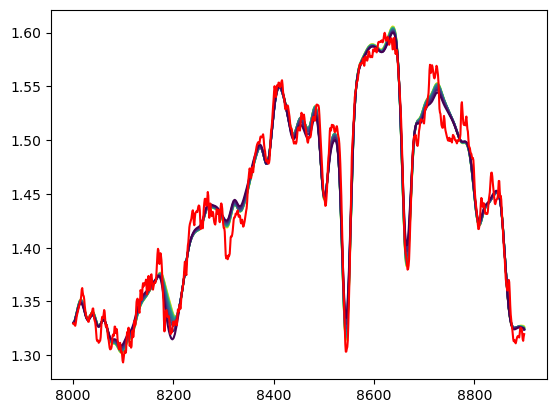

In [10]:
values = np.linspace(0.5,3.0,10)
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.viridis_r(norm(values))

for j,x in enumerate(values):
    params = (1.1,0.0,x,x,0.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.0,10.0,-10.0)
    wl_d_region, flux_d_region, dflux_d_region, flux_m_region, flux_mn_region = model_flux_regions(params)
    i=2
    flux_m_region[i].block_until_ready()
    plt.plot(wl_d_region[i],flux_mn_region[i],c=colors[j])

plt.plot(wl_d_region[i],flux_d_region[i],color='red')
#plt.plot(flux_m_region[i])



In [11]:
from model import model
mo = model(indata_file)


Indata loaded
Loading SSP grid
Smoothing ssp grid to ires...
Done!
Loading abundance grid
Smoothing abundance grid to ires...
Done
Loading hot star grid
Smoothing hot star to ires...
Loading M7III star
Smoothing hot star to ires...
Region 0 has size 600.00 ang, normalized with poly degree 6
Region 1 has size 900.00 ang, normalized with poly degree 9
Region 2 has size 900.00 ang, normalized with poly degree 9
Region 3 has size 600.00 ang, normalized with poly degree 6


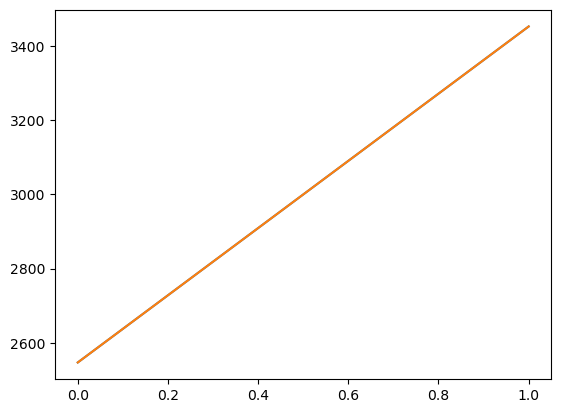

In [12]:
i=2
plt.plot(mo.fit_regions_data_ind[i])
plt.plot(fit_regions_data_ind[i])

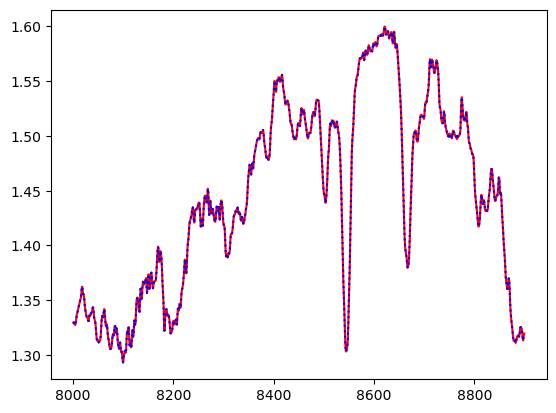

In [13]:
i=2
params = (1.1,0.0,1.3,2.3,0.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.0,10.0,-10.0)

wl_d_region, flux_d_region, dflux_d_region, flux_m_region, flux_mn_region = model_flux_regions(params)
flux_m_region[i].block_until_ready()
plt.plot(wl_d_region[i],flux_d_region[i],c='red')

wl_d_region, flux_d_region, dflux_d_region, flux_m_region, flux_mn_region = mo.model_flux_regions(params)
flux_m_region[i].block_until_ready()
plt.plot(wl_d_region[i],flux_d_region[i],c='blue',linestyle=':')

In [43]:
params = (1.0,0.0,1.3,2.3,-100.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,10.0,-6.0)
y = func(params).block_until_ready()
grad_y = grad(func)(params)
print(y)
print(grad_y)

time_to_complete = []

for i in tqdm(range(500)):
    start = time.time()
    y = func(params)

    grad_y = grad(func)(params)

    grad_y[2].block_until_ready()
    end = time.time()
    time_to_complete.append(end-start)

print(np.mean(time_to_complete))


    


3.6982021
(Array(0.00506409, dtype=float32, weak_type=True), Array(-0.02237134, dtype=float32, weak_type=True), Array(-0.00160162, dtype=float32, weak_type=True), Array(-0.00279359, dtype=float32, weak_type=True), Array(-2.900792e-06, dtype=float32, weak_type=True), Array(0.00013417, dtype=float32, weak_type=True), Array(-0.01542638, dtype=float32, weak_type=True), Array(0.01152829, dtype=float32, weak_type=True), Array(-0.06648721, dtype=float32, weak_type=True), Array(0.04318269, dtype=float32, weak_type=True), Array(0.01156576, dtype=float32, weak_type=True), Array(-0.01447929, dtype=float32, weak_type=True), Array(0.00863527, dtype=float32, weak_type=True), Array(-0.00146494, dtype=float32, weak_type=True), Array(-0.00358034, dtype=float32, weak_type=True), Array(0.00098017, dtype=float32, weak_type=True), Array(0.00043191, dtype=float32, weak_type=True), Array(0.00322429, dtype=float32, weak_type=True), Array(0.00250209, dtype=float32, weak_type=True), Array(-0.00206631, dtype=flo

  0%|          | 0/500 [00:00<?, ?it/s]

0.01737055683135986


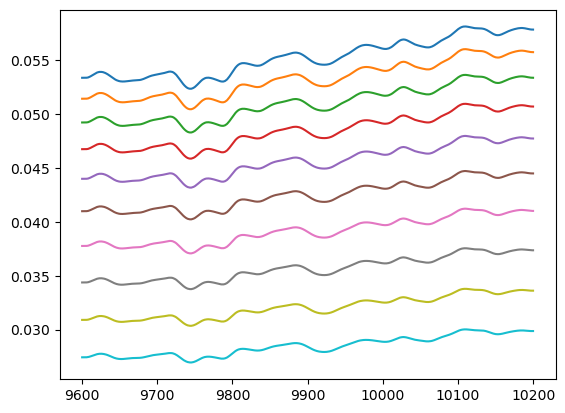

In [44]:
for x in jnp.linspace(1.3,3,10):
    params = (1.0,0.0,x,2.3,100.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,10.0,-6.0)
    wl_d_region, flux_d_region, dflux_d_region, flux_m_region, flux_mn_region = model_flux_regions(params)
    i=3
    #plt.errorbar(wl_d_region[i],flux_d_region[i],dflux_d_region[i])
    plt.plot(wl_d_region[i],flux_m_region[i])

In [45]:
region_name_list = []
for i in range(n_regions):
    region_name_list.append(f"Region {i+1}")

def vel_fit():
    #fit just velz and sigma
    velz = numpyro.sample('velz', dist.Normal(0.0,3))
    velz = velz * 100
    sigma = numpyro.sample('sigma', dist.Uniform(0.2,5))
    sigma = sigma * 100
    df = numpyro.sample("df", dist.Exponential(1.0))  

    params = (jnp.log10(8.0),0.0,1.3,2.3,velz,sigma,\
              0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,10.0,-6.0)
    _, _, _, flux_m_region, flux_mn_region = model_flux_regions(params)
    for i in range(n_regions):
        numpyro.sample(region_name_list[i],dist.StudentT(df,flux_mn_region[i],dflux_d_region[i]),obs=flux_d_region[i])

rng_key = random.PRNGKey(42)
kernel = NUTS(vel_fit)
mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=200,
)
mcmc.run(rng_key)
mcmc.print_summary()
vel_posterior_samples = mcmc.get_samples()


sample: 100%|██████████| 700/700 [01:02<00:00, 11.16it/s, 11 steps of size 3.65e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        df      0.59      0.01      0.59      0.57      0.61     82.48      1.00
     sigma      2.16      0.02      2.16      2.12      2.20     52.50      1.00
      velz      0.36      0.04      0.35      0.30      0.44     40.43      1.00

Number of divergences: 0


In [46]:
velz_mean_est = jnp.mean(vel_posterior_samples['velz'])
velz_std_est = jnp.std(vel_posterior_samples['velz'])
sigma_mean_est = jnp.mean(vel_posterior_samples['sigma'])
sigma_std_est = jnp.std(vel_posterior_samples['sigma'])

In [47]:
def model_fit():
    #define priors here
    '''age = numpyro.sample("age", dist.Uniform(8,14))
    logage = jnp.log10(age)'''
    logage = numpyro.sample("age", dist.Uniform(0.5,1.14))
    Z = numpyro.sample('Z', dist.Uniform(-1.8,0.3))
    imf1 = numpyro.sample('imf1', dist.Uniform(0.5,3.5))
    imf2 = numpyro.sample('imf2', dist.Uniform(0.5,3.5))
    velz = numpyro.sample('velz', dist.Normal(velz_mean_est,1))
    velz = velz * 100
    sigma = numpyro.sample('sigma', dist.Uniform(0.5,5))
    sigma = sigma * 100

    nah = numpyro.sample('nah',dist.Uniform(-0.3,1))
    cah = numpyro.sample('cah',dist.Uniform(-0.3,0.5))
    feh = numpyro.sample('feh',dist.Uniform(-0.3,0.5))

    ch = numpyro.sample('ch',dist.Uniform(-0.3,0.5))
    nh = numpyro.sample('nh',dist.Uniform(-0.3,1))
    ah = numpyro.sample('ah',dist.Uniform(-0.3,0.5))
    tih = numpyro.sample('tih',dist.Uniform(-0.3,0.5))
    mgh = numpyro.sample('mgh',dist.Uniform(-0.3,0.5))
    sih = numpyro.sample('sih',dist.Uniform(-0.3,0.5))
    mnh = numpyro.sample('mnh',dist.Uniform(-0.3,0.5))
    bah = numpyro.sample('bah',dist.Uniform(-0.6,0.5))
    nih = numpyro.sample('nih',dist.Uniform(-0.3,0.5))
    coh = numpyro.sample('coh',dist.Uniform(-0.3,0.5))
    euh = numpyro.sample('euh',dist.Uniform(-0.6,0.5))
    srh = numpyro.sample('srh',dist.Uniform(-0.3,0.5))
    kh = numpyro.sample('kh',dist.Uniform(-0.3,0.5))
    vh = numpyro.sample('vh',dist.Uniform(-0.3,0.5))
    cuh = numpyro.sample('cuh',dist.Uniform(-0.3,0.5))

    teff = numpyro.sample('teff',dist.Uniform(-0.5,0.5))
    teff = teff*100

    loghot = numpyro.sample('loghot',dist.Uniform(-6.0,-1.0))
    hotteff = numpyro.sample('hotteff',dist.Uniform(8.0,30.0))
    logm7g = numpyro.sample('logm7g',dist.Uniform(-6.0,-1.0))

    #df = numpyro.sample("df", dist.Exponential(1.0))  

    params = (logage,Z,imf1,imf2,velz,sigma,\
              nah,cah,feh,ch,nh,ah,tih,mgh,sih,mnh,bah,nih,coh,euh,srh,kh,vh,cuh,teff,\
                loghot,hotteff,logm7g)
    _, _, _, flux_m_region, flux_mn_region = model_flux_regions(params)
    for i in range(n_regions):
        numpyro.sample(region_name_list[i],dist.Normal(flux_mn_region[i],dflux_d_region[i]*error_mult),obs=flux_d_region[i])

rng_key = random.PRNGKey(42)
kernel = NUTS(model_fit)
mcmc = MCMC(
    kernel,
    num_warmup=500,
    num_samples=1500,
)
mcmc.run(rng_key)

sample: 100%|██████████| 2000/2000 [14:00<00:00,  2.38it/s, 63 steps of size 1.11e-01. acc. prob=0.93]  


In [48]:
# Step 4: Summarize the results
mcmc.print_summary()

# Optional: Get samples
posterior_samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         Z     -0.05      0.00     -0.05     -0.06     -0.05    599.21      1.00
       age      1.14      0.00      1.14      1.14      1.14   2332.66      1.00
        ah      0.16      0.01      0.16      0.13      0.18    920.29      1.00
       bah     -0.29      0.05     -0.29     -0.37     -0.22   2243.23      1.00
       cah      0.09      0.00      0.09      0.09      0.10    797.85      1.00
        ch      0.21      0.00      0.21      0.20      0.21    679.32      1.00
       coh      0.06      0.01      0.06      0.03      0.08   1749.27      1.00
       cuh      0.46      0.03      0.47      0.42      0.50   2243.25      1.00
       euh      0.49      0.01      0.50      0.48      0.50   2199.67      1.00
       feh      0.03      0.00      0.03      0.03      0.04    598.88      1.00
   hotteff      8.34      0.35      8.23      8.00      8.77    573.99      1.00
      imf1      1.95      0

In [ ]:
'''param_list = ['age','Z','imf1','imf2','velz','sigma','nah','cah','feh','ch','nh',
              'ah','tih','mgh','sih','mnh','bah','nih','coh','euh','srh','kh','vh','cuh','teff',
              'loghot','hotteff','logm7g']'''
param_list = ['age','Z','imf1','velz','sigma','nah','cah','feh','ch','nh',
              'ah','tih','mgh','sih','mnh','bah','nih','coh','euh','srh','kh','vh','cuh','teff',
              'loghot','hotteff','logm7g']
params = []
for pname in param_list:
    if pname == 'age':
        params.append(np.mean(np.log10(posterior_samples[pname])))
        '''elif pname == 'imf1':
        params.append(np.mean(posterior_samples[pname]))
        params.append(np.mean(posterior_samples[pname]))'''
    elif (pname == 'velz') or (pname == 'sigma') or (pname=='teff'):
        params.append(np.mean(posterior_samples[pname])*100)
    else:
        params.append(np.mean(posterior_samples[pname]))

In [50]:
len(params)

28

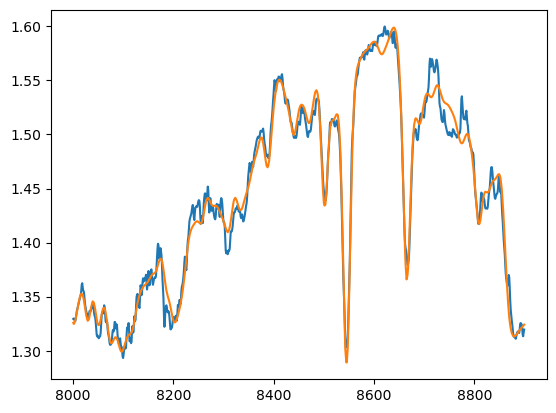

In [51]:
wl_d_region, flux_d_region, dflux_d_region, flux_m_region, flux_mn_region = model_flux_regions(params)
i = 2
plt.plot(wl_d_region[i],flux_d_region[i])
plt.plot(wl_d_region[i],flux_mn_region[i])

In [52]:
import arviz as az

idata = az.from_numpyro(mcmc)

array([[<Axes: ylabel='age'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='Z'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='imf1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='imf2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='velz'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='logm7g'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: xlabel='age', ylabel='nah'>, <Axes: xlabel='Z'>,
        <Axes: xlabel='imf1'>, <Axes: xlabel='imf2'>,
        <Axes: xlabel='velz'>, <Axes: xlabel='logm7g'>,
        <Axes: xlabel='nah'>]], dtype=object)

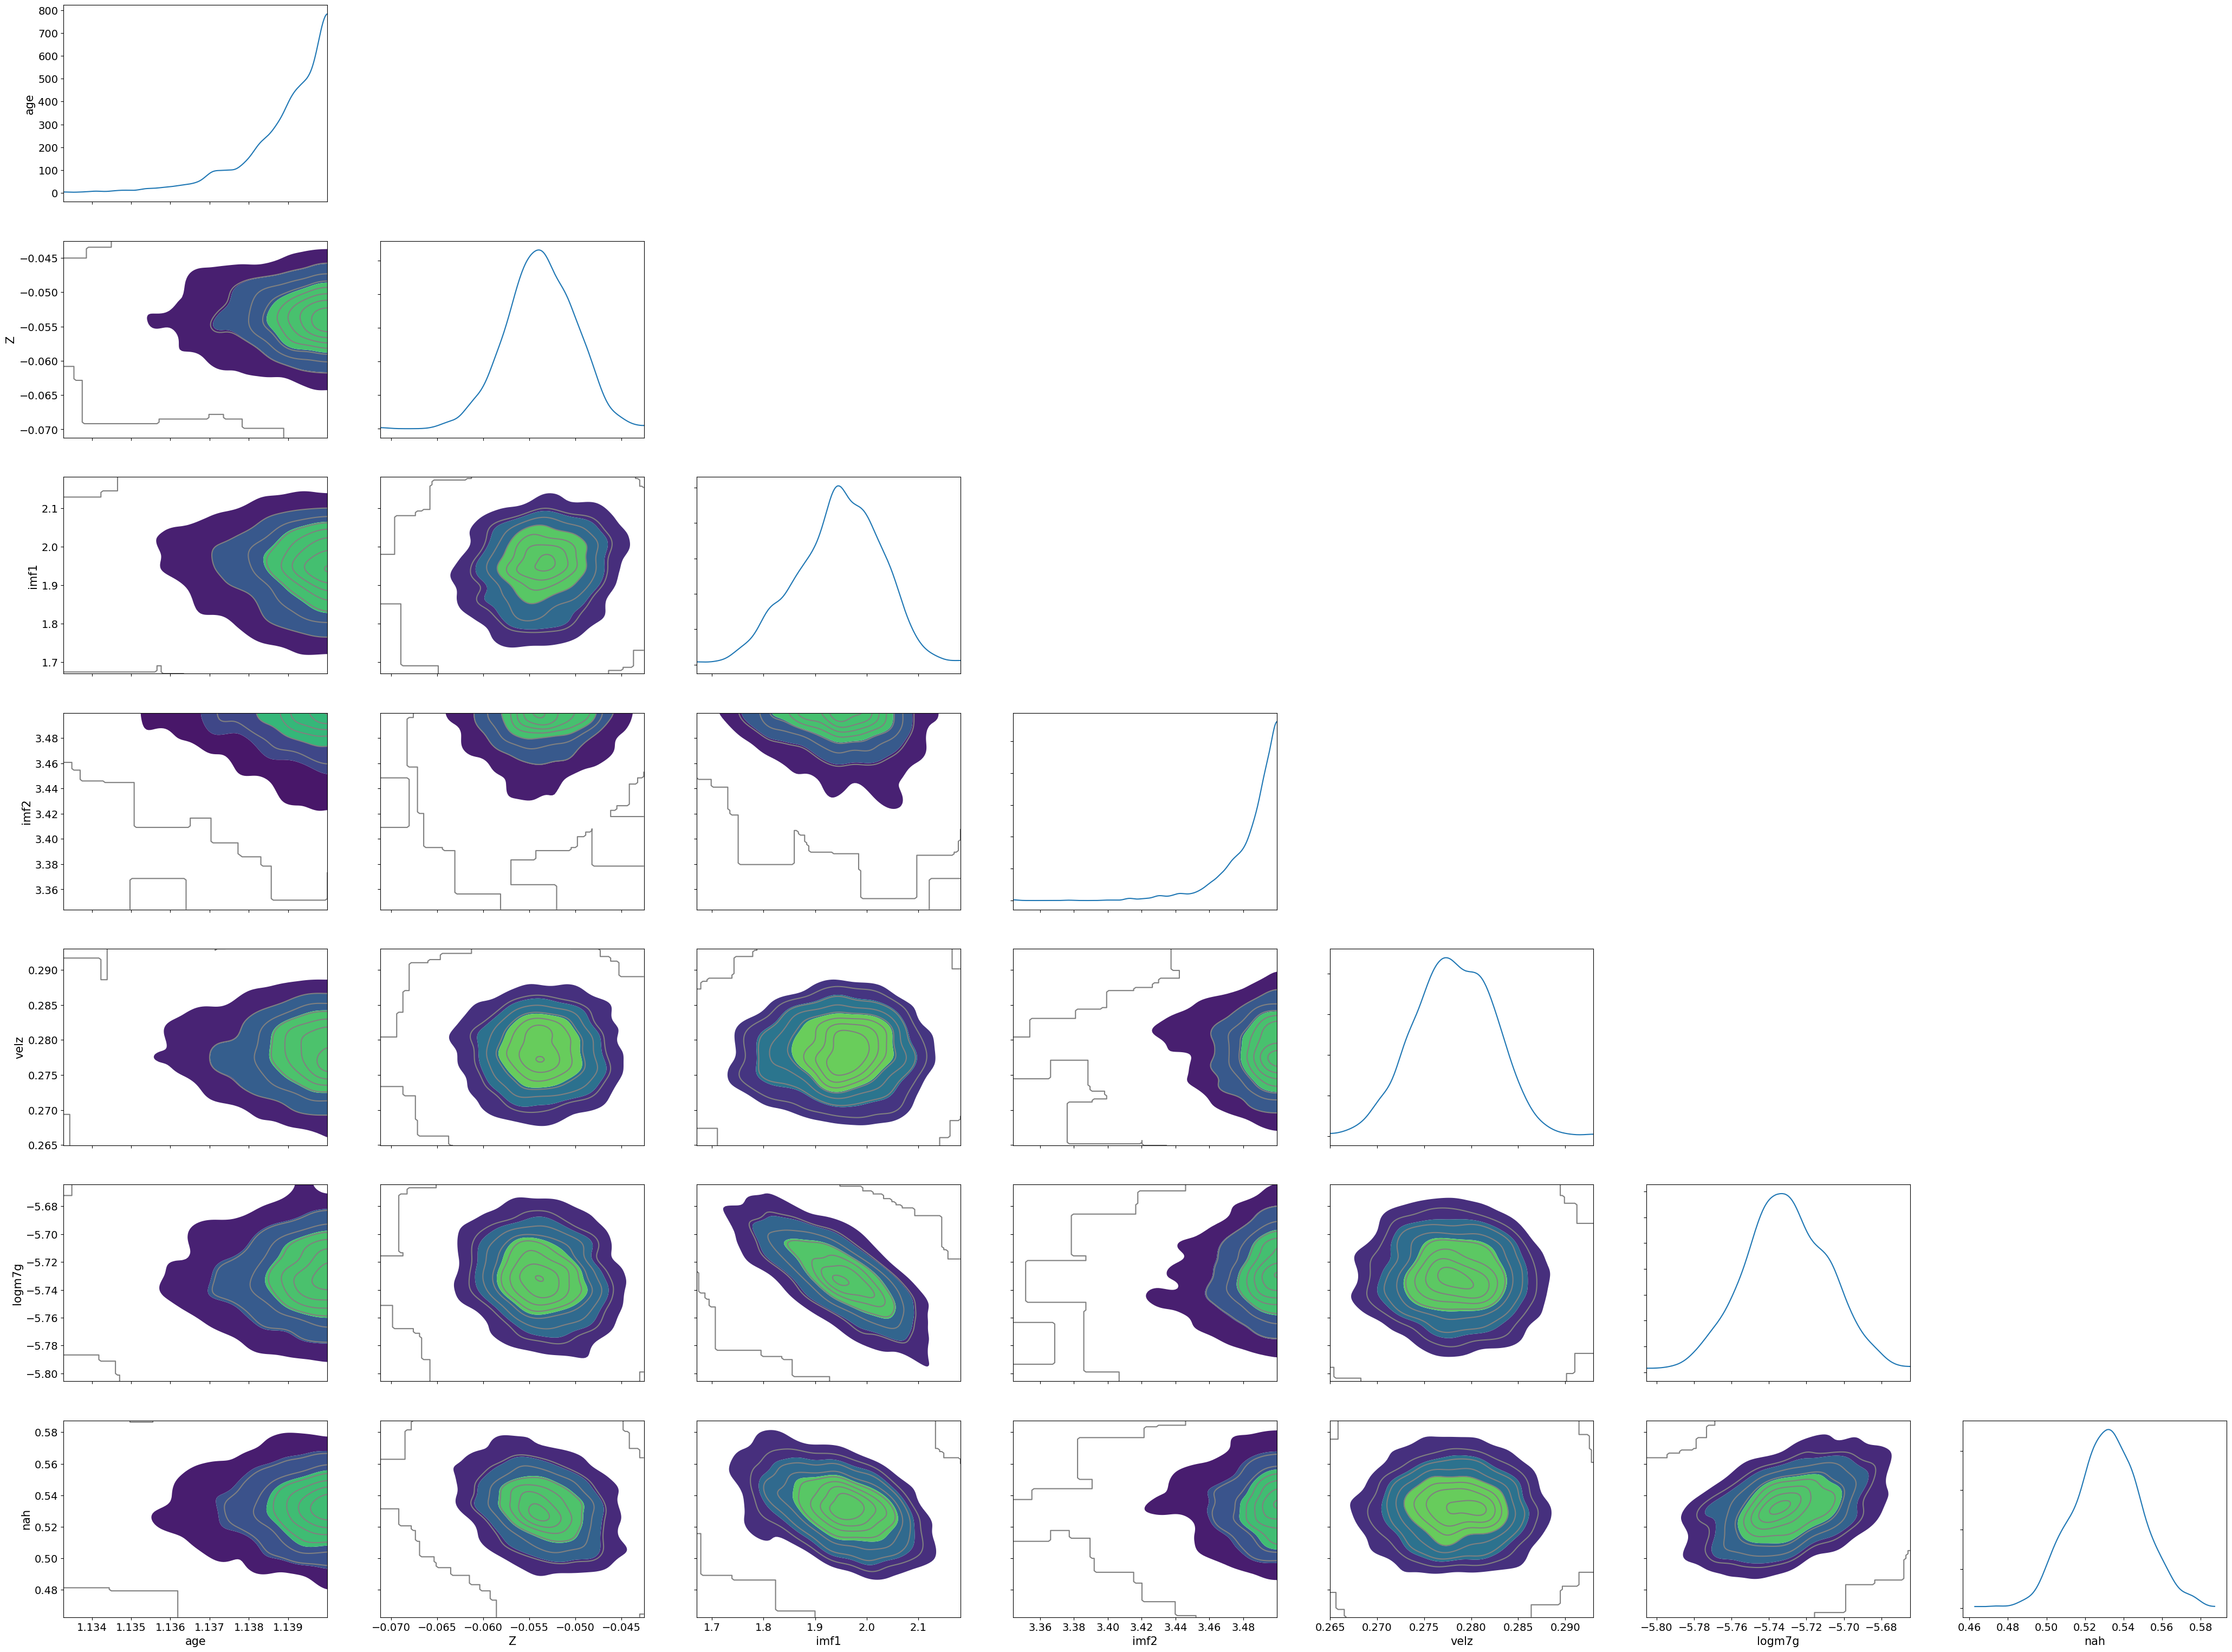

In [53]:
az.plot_pair(idata, 
             var_names=['age','Z','imf1','imf2','velz','logm7g','nah'],
             kind='kde',
             marginals=True)

age,Z,imf1,imf2,velz,sigma,nah,cah,feh,ch,nh,ah,tih,mgh,sih,mnh,bah,nih,coh,euh,srh,kh,vh,cuh,teff